# Compare clustering and manual gating

In this notebook, we compare the gating results of different experts with the clustering results.

The first question is how well the pre-processing filters for living cells and singlets overlap. We decided that we will assess gating purity only based on the intersection of all filtering results. This way, we ensure that assessing the gating quality is less biased by the pro-processing decisions of each person.

In [47]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
import datetime
#import pytometry as pm
import sklearn.metrics 
from upsetplot import plot, UpSet

import os

sc.logging.print_versions()
sc.settings.verbosity = 3 

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
asciitree           NA
asttokens           NA
backcall            0.2.0
cffi                1.15.1
cloudpickle         2.0.0
colorama            0.4.5
cupy                9.6.0
cupy_backends       NA
cupyx               NA
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2022.01.0
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           0.9.1
fasteners           0.17.3
fastrlock           0.8
fontTools           4.35.0
fsspec              2022.7.1
google              NA
h5py                3.1.0
ipykernel           6.15.1
ipython_genutils    0.2.0
ipywidgets          7.7.1
jedi                0.18.1
jinja2              3.1.2
joblib              1.1.0
jupyter_server      1.18.1
kiwisolver          1.4.4
llvmlite            0.38.1
lxml                4.9.1
markupsafe          2.

In [2]:
sc.settings.figdir = './../figures/' 

Add date.

In [3]:
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [4]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 80))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,10))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## Read data

In [6]:
data_path = './../data/Convex_gating_test_MB/'

In [7]:
adata_con = sc.read(data_path + 'anndata/' + 'adata_concatenated_manGates.h5ad')

## A cell-centric certainty measure

In order to determine the annotation quality and reproducibility, we have to consider several aspects. Some cell types such as B cells and monocytes are abundant and have a clear marker pattern and are easy to distinguish. Others like dendritic cells and their subtypes are rare, have a less clear marker pattern and are less easy to gate. We aim to account for both the difficulty to gate a population and its abundance when we assess the quality and reproducibility of a gating strategy and the resulting cell type annotation. 

We obtained several gating submission from experts in flow cytometry analysis in the lab. To compare all submissions and  to establish a certainty metric for the annotation of each cell, we use a cell-centric approach. We determine the final label for each cell as the majority of the labels given this cell. Next, we define the certainty of the label assigned to cell $j$ by the inverse Simpson index (ISI):

\begin{equation}
x_{j, \text{ISI}} = \left(\sum_{i=1}^R \left(\frac{n_{ij}}{N}\right)^2\right)^{-1}
\end{equation}

Where R is the number of possible labels (i.e. the cell types in a dataset) and $n_i$ corresponds to the number of labels of cell type $i$ that have been assigned to the cell $j$. $N$ is the total number of gating submissions. 

The inverse Simpson index is a diversity score that determines the effective number of parties in a set. In our case, it corresponds to the effective number of different cell type labels assigned to a cell $j$. When all experts assigned the same label to a cell $j$, the ISI is 1. When all $N$ experts assigned a different label to a cell $j$, the ISI equals to $N$. We further scale the ISI, such that 0 corresponds to a different label from every expert gating and 1 is the consistent label from all experts:

\begin{equation}
z_{j, \text{ISI}} = \frac{x_{j, \text{ISI}} - N}{1 - N} \qquad \forall N > 1
\end{equation}


In [262]:
def inverse_simpson(x: np.ndarray = np.arange(1,11), 
                    scale: bool = True, 
                    axis: int = 0):
    #add documentation
    
    #get shape of x
    x_shape = np.array(x.shape)
    dims = len(x_shape)
    #get total number of entries
    if dims <= axis:
        print((f"The axis of {axis} is larger than "
               "the number of dimensions of x."))
        return
    N = x_shape[axis]
    #get number of entries per class over a specified axis
    if dims>1:
        x_shape = np.delete(x_shape, axis)
        #take the first (new) axis the number of events
        n_events = x_shape[0]
        x_isi = np.zeros(n_events)
        for idx in range(n_events):
            if axis == 0:
                x_sub = np.asarray(x)[:, idx]
            elif axis == 1:
                x_sub = np.asarray(x)[idx]
            else:
                print((f"Subsetting for axis > {axis} not defined."
                      " Provide a smaller axis value."))
                return
            
            _, counts = np.unique(x_sub, return_counts = True)
            #sum over all counts per class squared
            x_isi[idx] = 1/np.sum((counts/N)**2)
    else:
        _, counts = np.unique(x, return_counts = True)
        #sum over all counts per class squared
        x_isi = 1/np.sum((counts/N)**2)
    #scale 
    if scale and N>1:
        z_isi = (x_isi-N)/(1-N)
        return z_isi
    else:
        return x_isi
        

In [263]:
def inverse_simpson_pandas(df: pd.DataFrame, 
                    scale: bool = True, 
                    axis: int = 1):
    #add documentation
    
    #get shape of x
    x_shape = np.array(df.shape)
    dims = len(x_shape)
    #get total number of entries
    if dims <= axis:
        print((f"The axis of {axis} is larger than "
               "the number of dimensions of x."))
        return
    N = x_shape[axis]
    
    #initialise output
    major_celltype = list()
    x_isi_all = list()
    
    #create counts
    values = df.aggregate(np.unique,  **{'return_counts' : True}, axis=axis)
    
    for cell_types, counts in values:
        #get cell type label from majority vote
        major_celltype.append(cell_types[np.argmax(counts)])

        #sum over all counts per class squared
        x_isi = 1/np.sum((counts/N)**2)
    
        #scale 
        if scale and N>1:
            z_isi = (x_isi-N)/(1-N)
            x_isi_all.append(z_isi)
        
        else:
            x_isi_all.append(x_isi)
    
    return major_celltype, x_isi_all

### cell type level 1

In [233]:
anno_keys = [key for key in adata_con.obs_keys() if key.count('cell type lvl 1')>0]

In [234]:
anno_keys

['cell type lvl 1',
 'manual cell type lvl 1_Gold',
 'manual cell type lvl 1_p1',
 'manual cell type lvl 1_p2',
 'manual cell type lvl 1_p3',
 'manual cell type lvl 1_p4',
 'manual cell type lvl 1_p5',
 'manual cell type lvl 1_p6',
 'manual cell type lvl 1_p7.1',
 'manual cell type lvl 1_p7.2',
 'manual cell type lvl 1_p7.3',
 'manual cell type lvl 1_p7.4']

In [236]:
anno_cells = adata_con.obs[anno_keys]

In [237]:
anno_cells.head()

,cell type lvl 1,manual cell type lvl 1_Gold,manual cell type lvl 1_p1,manual cell type lvl 1_p2,manual cell type lvl 1_p3,manual cell type lvl 1_p4,manual cell type lvl 1_p5,manual cell type lvl 1_p6,manual cell type lvl 1_p7.1,manual cell type lvl 1_p7.2,manual cell type lvl 1_p7.3,manual cell type lvl 1_p7.4
0-0,T cell,not annotated,not annotated,T cell,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated
1-0,not annotated,T cell,T cell,Monocyte,T cell,not annotated,T cell,T cell,T cell,T cell,T cell,T cell
2-0,not annotated,NK cell,NK cell,not annotated,NK cell,not annotated,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell
3-0,not annotated,Monocyte,Monocyte,Monocyte,Dendritic cell,Monocyte,Monocyte,Monocyte,Monocyte,Monocyte,Monocyte,Monocyte
4-0,not annotated,NK cell,NK cell,T cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell


In [264]:
div_ili = inverse_simpson_pandas(anno_cells, axis = 1)

In [268]:
dfi = pd.DataFrame(data={'consensus label': div_ili[0], 'scaled ISI': div_ili[1], 'sample': adata_con.obs['sample'].cat.codes})

In [278]:
dfi['consensus label'] = pd.Categorical(dfi['consensus label'], categories= dfi['consensus label'].value_counts().index.values)

Generate a boxplot for the scaled Inverse Simpson index per cell type and sample.

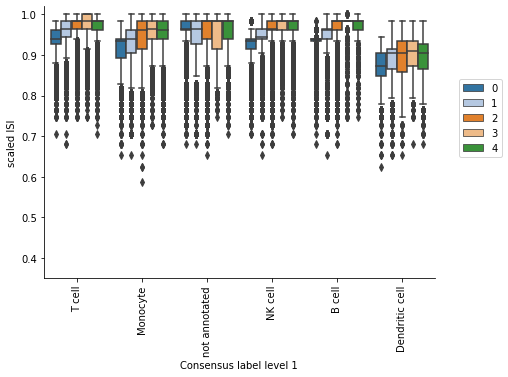

In [313]:
fig = plt.figure(figsize=(7,5))
p7 = sns.boxplot(data =dfi, x='consensus label', y='scaled ISI', hue='sample', palette='tab20')
p7.legend(bbox_to_anchor=(1.05,0.75))
p7.set_xlabel('Consensus label level 1')
p7.set_xticklabels(p7.get_xticklabels(), rotation=90)
p7.set_ylim([0.35,1.02])
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_ISI_level1.pdf', bbox_inches='tight')
plt.show()

Unscaled version.

In [314]:
div_ili0 = inverse_simpson_pandas(anno_cells, axis = 1, scale=False)

In [315]:
dfi0 = pd.DataFrame(data={'consensus label': div_ili0[0], 'ISI': div_ili0[1], 'sample': adata_con.obs['sample'].cat.codes})

In [316]:
dfi0['consensus label'] = pd.Categorical(dfi0['consensus label'], categories= dfi0['consensus label'].value_counts().index.values)

Generate a boxplot for the scaled Inverse Simpson index per cell type and sample.

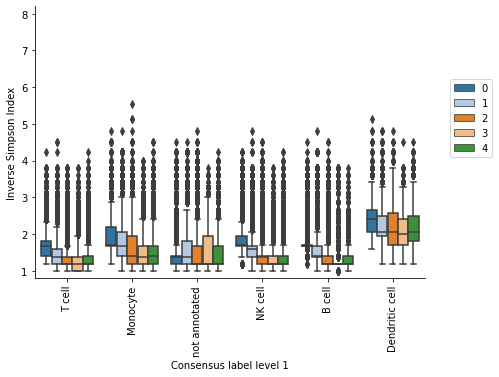

In [330]:
fig = plt.figure(figsize=(7,5))
p7 = sns.boxplot(data =dfi0, x='consensus label', y='ISI', hue='sample', palette='tab20')
p7.legend(bbox_to_anchor=(1.05,0.75))
p7.set_xlabel('Consensus label level 1')
p7.set_ylabel('Inverse Simpson Index')
p7.set_xticklabels(p7.get_xticklabels(), rotation=90)
p7.set_ylim([0.8,8.2])
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_unscaledISI_level1.pdf', bbox_inches='tight')
plt.show()

### cell type level 2

In [282]:
anno_keys2 = [key for key in adata_con.obs_keys() if key.count('cell type lvl 2')>0]

In [283]:
anno_keys2

['cell type lvl 2',
 'manual cell type lvl 2_Gold',
 'manual cell type lvl 2_p1',
 'manual cell type lvl 2_p2',
 'manual cell type lvl 2_p3',
 'manual cell type lvl 2_p4',
 'manual cell type lvl 2_p5',
 'manual cell type lvl 2_p6',
 'manual cell type lvl 2_p7.1',
 'manual cell type lvl 2_p7.2',
 'manual cell type lvl 2_p7.3',
 'manual cell type lvl 2_p7.4']

In [284]:
anno_cells2 = adata_con.obs[anno_keys2]

In [285]:
anno_cells2.head()

,cell type lvl 2,manual cell type lvl 2_Gold,manual cell type lvl 2_p1,manual cell type lvl 2_p2,manual cell type lvl 2_p3,manual cell type lvl 2_p4,manual cell type lvl 2_p5,manual cell type lvl 2_p6,manual cell type lvl 2_p7.1,manual cell type lvl 2_p7.2,manual cell type lvl 2_p7.3,manual cell type lvl 2_p7.4
0-0,CD4+ T cell,not annotated,not annotated,CD4+ T cell,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated
1-0,not annotated,CD8+ T cell,T cell,Classical monocyte,CD8+ T cell,not annotated,not annotated,CD8+ T cell,CD8+ T cell,CD8+ T cell,CD8+ T cell,CD8+ T cell
2-0,not annotated,NK cell,NK cell,not annotated,NK cell,not annotated,not annotated,NK cell,NK cell,NK cell,NK cell,NK cell
3-0,not annotated,Classical monocyte,Classical monocyte,Classical monocyte,cDC,Classical monocyte,Classical monocyte,Classical monocyte,Classical monocyte,Classical monocyte,Classical monocyte,Classical monocyte
4-0,not annotated,NK cell,NK cell,CD8+ T cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell


In [286]:
div_ili2 = inverse_simpson_pandas(anno_cells2, axis = 1)

In [287]:
dfi2 = pd.DataFrame(data={'consensus label': div_ili2[0], 'scaled ISI': div_ili2[1], 'sample': adata_con.obs['sample'].cat.codes})

In [288]:
dfi2['consensus label'] = pd.Categorical(dfi2['consensus label'], categories= dfi2['consensus label'].value_counts().index.values)

Generate a boxplot for the scaled Inverse Simpson index per cell type and sample.

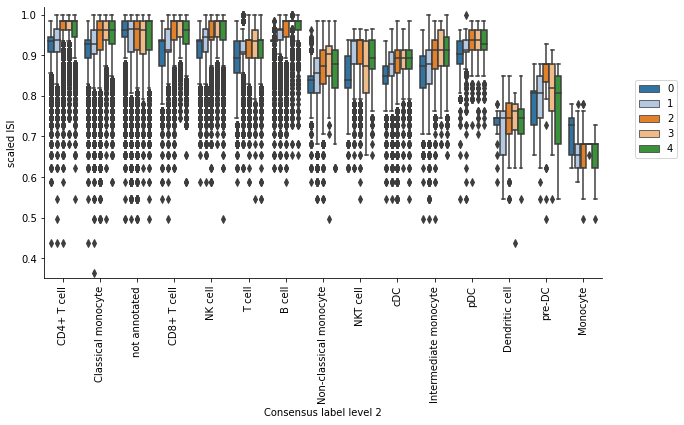

In [311]:
fig = plt.figure(figsize=(10,5))
p7 = sns.boxplot(data =dfi2, x='consensus label', y='scaled ISI', hue='sample',palette='tab20')
p7.legend(bbox_to_anchor=(1.05,0.75))
p7.set_xlabel('Consensus label level 2')
p7.set_xticklabels(p7.get_xticklabels(), rotation=90)
p7.set_ylim([0.35,1.02])
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_ISI_level2.pdf', bbox_inches='tight')
plt.show()

Unscaled version.

In [321]:
div_ili02 = inverse_simpson_pandas(anno_cells2, axis = 1, scale=False)

In [322]:
dfi02 = pd.DataFrame(data={'consensus label': div_ili02[0], 'ISI': div_ili02[1], 'sample': adata_con.obs['sample'].cat.codes})

In [323]:
dfi02['consensus label'] = pd.Categorical(dfi02['consensus label'], categories= dfi02['consensus label'].value_counts().index.values)

Generate a boxplot for the scaled Inverse Simpson index per cell type and sample.

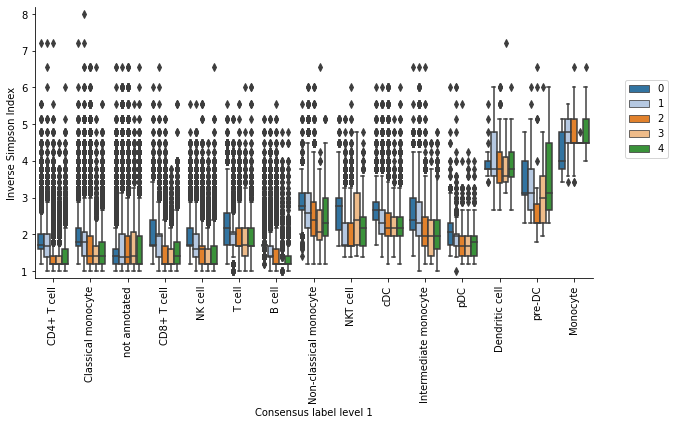

In [328]:
fig = plt.figure(figsize=(10,5))
p7 = sns.boxplot(data =dfi02, x='consensus label', y='ISI', hue='sample', palette='tab20')
p7.legend(bbox_to_anchor=(1.05,0.75))
p7.set_xlabel('Consensus label level 1')
p7.set_ylabel('Inverse Simpson Index')
p7.set_xticklabels(p7.get_xticklabels(), rotation=90)
p7.set_ylim([0.8,8.2])
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_unscaledISI_level2.png', bbox_inches='tight')
plt.show()

## Level 0: Valid cells

Selection of valid cells are denoted as:

In [334]:
debris_keys = [key for key in adata_con.obs_keys() if key.count('cell debris')>0]

In [335]:
joint_cells = adata_con.obs[debris_keys]

In [336]:
joint_cells.head()

,cell debris,manual cell debris_Gold,manual cell debris_p1,manual cell debris_p2,manual cell debris_p3,manual cell debris_p4,manual cell debris_p5,manual cell debris_p6,manual cell debris_p7.1,manual cell debris_p7.2,manual cell debris_p7.3,manual cell debris_p7.4
0-0,valid cell,debris,debris,valid cell,debris,debris,debris,debris,debris,debris,debris,valid cell
1-0,debris,valid cell,valid cell,valid cell,valid cell,debris,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell
2-0,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell
3-0,debris,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell
4-0,debris,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell,valid cell


In [12]:
res = {}
for key in debris_keys:
    res[key] = sklearn.metrics.jaccard_score(y_true=joint_cells['manual cell debris_Gold'],
                                             y_pred=joint_cells[key],
                                             pos_label='valid cell'
                                            )
    

In [13]:
res.pop('manual cell debris_Gold')

1.0

In [14]:
res

{'cell debris': 0.7804280057168854,
 'manual cell debris_p1': 0.9637131869556361,
 'manual cell debris_p2': 0.7677353421645517,
 'manual cell debris_p3': 0.9654241570977894,
 'manual cell debris_p4': 0.7868021011965362,
 'manual cell debris_p5': 0.9585829725540244,
 'manual cell debris_p6': 0.7186726178445854,
 'manual cell debris_p7.1': 0.9780628648557969,
 'manual cell debris_p7.2': 0.9779047997211263,
 'manual cell debris_p7.3': 0.9780186885394759,
 'manual cell debris_p7.4': 0.7216807044296831}

In [15]:
df = pd.Series(res)
df0 = pd.DataFrame(data={'Person': df.index, 'Jaccard': df.values})

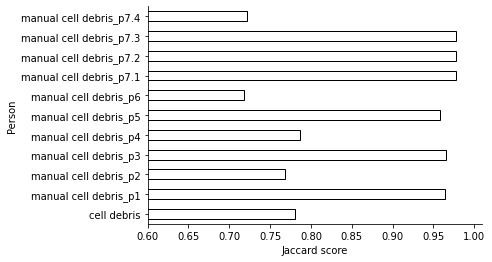

In [18]:
p0 = df0.plot.barh(x='Person', y='Jaccard', color='white', edgecolor='black')
p0.legend().remove()
p0.set_xlabel('Jaccard score')
p0.spines['top'].set_visible(False)
p0.spines['right'].set_visible(False)
p0.set_xlim([0.6,1.01])
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells.png', bbox_inches='tight')
plt.show()

To compute a hierarchical clustering, we have to compute the pairwise Jaccard score for all combinations.

In [88]:
res = {}
for key in [debris_comp] + debris_keys:
    res_tmp = []
    print(key)
    for key1 in [debris_comp] + debris_keys:
        print(key1)
        tmp = sklearn.metrics.jaccard_score(y_true=joint_cells[key],
                                             y_pred=joint_cells[key1],
                                             pos_label='valid cell'
                                            )
        res_tmp.append(tmp)
    res[key] = res_tmp

cell debris
cell debris
manual cell debris_Gold
manual cell debris_p1
manual cell debris_p2
manual cell debris_p3
manual cell debris_p4
manual cell debris_p5
manual cell debris_p6
manual cell debris_p7.1
manual cell debris_p7.2
manual cell debris_p7.3
manual cell debris_p7.4
manual cell debris_Gold
cell debris
manual cell debris_Gold
manual cell debris_p1
manual cell debris_p2
manual cell debris_p3
manual cell debris_p4
manual cell debris_p5
manual cell debris_p6
manual cell debris_p7.1
manual cell debris_p7.2
manual cell debris_p7.3
manual cell debris_p7.4
manual cell debris_p1
cell debris
manual cell debris_Gold
manual cell debris_p1
manual cell debris_p2
manual cell debris_p3
manual cell debris_p4
manual cell debris_p5
manual cell debris_p6
manual cell debris_p7.1
manual cell debris_p7.2
manual cell debris_p7.3
manual cell debris_p7.4
manual cell debris_p2
cell debris
manual cell debris_Gold
manual cell debris_p1
manual cell debris_p2
manual cell debris_p3
manual cell debris_p4
manu

In [89]:
df = pd.DataFrame(res, index=res.keys())

In [90]:
df

,cell debris,manual cell debris_Gold,manual cell debris_p1,manual cell debris_p2,manual cell debris_p3,manual cell debris_p4,manual cell debris_p5,manual cell debris_p6,manual cell debris_p7.1,manual cell debris_p7.2,manual cell debris_p7.3,manual cell debris_p7.4
cell debris,1.000000,0.780428,0.764213,0.764537,0.765942,0.664810,0.764256,0.592762,0.777155,0.777120,0.777164,0.628510
manual cell debris_Gold,0.780428,1.000000,0.963713,0.767735,0.965424,0.786802,0.958583,0.718673,0.978063,0.977905,0.978019,0.721681
manual cell debris_p1,0.764213,0.963713,1.000000,0.748103,0.968144,0.810729,0.974168,0.724867,0.974801,0.974641,0.974746,0.718104
manual cell debris_p2,0.764537,0.767735,0.748103,1.000000,0.751325,0.622806,0.744724,0.579312,0.761159,0.761078,0.761160,0.635297
manual cell debris_p3,0.765942,0.965424,0.968144,0.751325,1.000000,0.805825,0.960613,0.721417,0.972394,0.972235,0.972350,0.720258
manual cell debris_p4,0.664810,0.786802,0.810729,0.622806,0.805825,1.000000,0.803442,0.627692,0.794316,0.794411,0.794319,0.621164
manual cell debris_p5,0.764256,0.958583,0.974168,0.744724,0.960613,0.803442,1.000000,0.727062,0.974743,0.974590,0.974689,0.717496
manual cell debris_p6,0.592762,0.718673,0.724867,0.579312,0.721417,0.627692,0.727062,1.000000,0.730272,0.730139,0.730232,0.561628
manual cell debris_p7.1,0.777155,0.978063,0.974801,0.761159,0.972394,0.794316,0.974743,0.730272,1.000000,0.999834,0.999928,0.728034
manual cell debris_p7.2,0.777120,0.977905,0.974641,0.761078,0.972235,0.794411,0.974590,0.730139,0.999834,1.000000,0.999880,0.727929


In [92]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [93]:
Z = linkage(df, "ward")

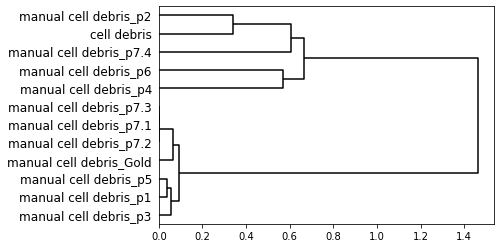

In [118]:
p2 = dendrogram(Z, labels = df.index, leaf_rotation=0, color_threshold=0, above_threshold_color='k', orientation='right')
plt.savefig(f'./../figures/{today}_gating_test_hierclust_valid_cells.pdf', bbox_inches='tight')
plt.show()

In [123]:
df_tmp = df['manual cell debris_Gold']

In [124]:
df_tmp.drop('manual cell debris_Gold', inplace=True)

In [151]:
df0 = pd.DataFrame(data={'Person': df_tmp.index, 'Jaccard': df_tmp.values})
df0['Person'] = pd.Categorical(df0['Person'], categories=p2['ivl'][::-1])
df0.sort_values('Person', inplace=True, ascending=False)

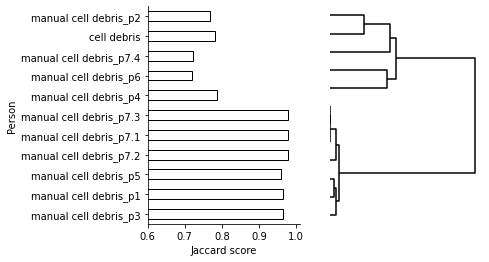

In [154]:
fig, axs = plt.subplots(1,2, sharey=False)
axs[0] = df0.plot.barh(x='Person', y='Jaccard', color='white', edgecolor='black', ax=axs[0])
axs[0].legend().remove()
axs[0].set_xlabel('Jaccard score')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_xlim([0.6,1.01])
p4 = dendrogram(Z, labels = np.repeat('', df.shape[0]), 
                    leaf_rotation=0, color_threshold=0, above_threshold_color='k', orientation='right', ax=axs[1])
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].get_xaxis().set_visible(False)
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells_hierclust.pdf', bbox_inches='tight')
plt.show()

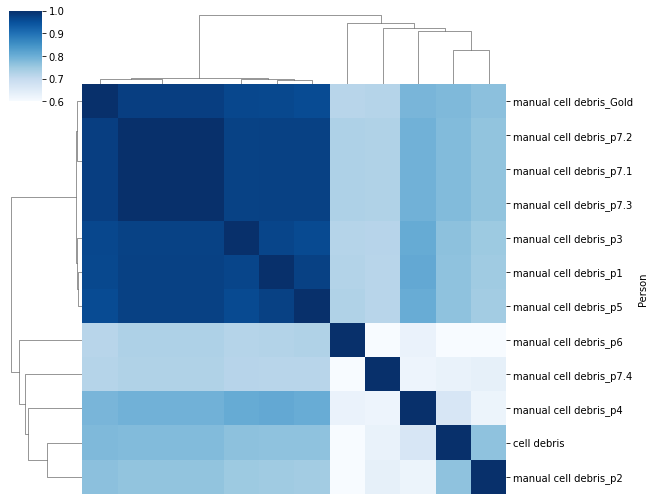

In [156]:
p3 = sns.clustermap(df, cmap='Blues', vmin=0.6, dendrogram_ratio=0.15, xticklabels=False, figsize=(9,7))
ax = p3.ax_heatmap
ax.set_ylabel('Person')
plt.savefig(f'./../figures/{today}_gating_test_overlap_valid_cells_clustermap.png', bbox_inches='tight')
plt.show()

Next, we visualize the number of cells recognized as valid in an upset plot.

In [25]:
len(joint_cells.columns)

12

In [27]:
list(joint_cells.columns.values)

['cell debris',
 'manual cell debris_Gold',
 'manual cell debris_p1',
 'manual cell debris_p2',
 'manual cell debris_p3',
 'manual cell debris_p4',
 'manual cell debris_p5',
 'manual cell debris_p6',
 'manual cell debris_p7.1',
 'manual cell debris_p7.2',
 'manual cell debris_p7.3',
 'manual cell debris_p7.4']

In [30]:
jc_bool = joint_cells=='valid cell'

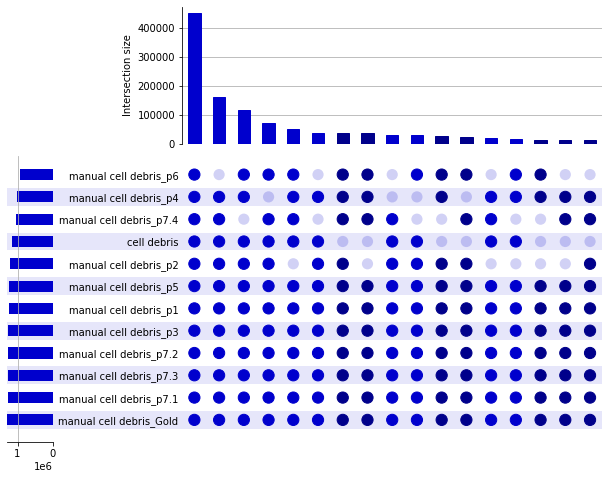

In [191]:
df_up = jc_bool.groupby(list(jc_bool.columns.values)).size()
upset = UpSet(df_up, orientation='horizontal', sort_by='cardinality', 
     min_subset_size=10000, subset_size='sum', 
     #show_percentages=True,
     min_degree=9,
     with_lines=False, facecolor="mediumblue",shading_color="lavender"
    )

upset.style_subsets(absent=["cell debris"],
                    facecolor="darkblue")

upset.plot()
plt.savefig(f'./../figures/{today}_overlap_valid_cells_upset.pdf', bbox_inches='tight')
plt.show()

Note: Simplify the categories of this plot to 'valid in all', 'valid in all but one', 'valid in all but 2'. And intersect with Gold standard and non-gating based cell selection.

In [162]:
valid_sum = np.sum(jc_bool, axis=1)

In [187]:
df = pd.crosstab(valid_sum, "sum valid")/jc_bool.shape[0]*100
df = df[::-1]

In [188]:
df

col_0,sum valid
row_0,
12,31.071068
11,30.665887
10,17.075470
9,6.587633
8,1.989907
7,0.709845
6,0.302795
5,0.261952
4,0.386767


In [193]:
jc_bool['manual cell debris_Gold'].mean()

0.8940922369750924

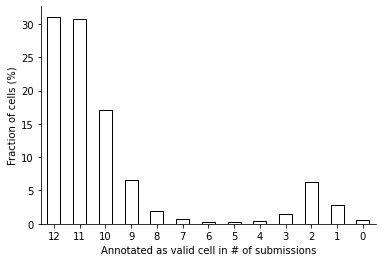

In [198]:
p5 = df.plot.bar(color='white', edgecolor='black',rot=0)
p5.legend().remove()
p5.set_xlabel('Annotated as valid cell in # of submissions')
p5.set_ylabel('Fraction of cells (%)')
p5.spines['top'].set_visible(False)
p5.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_overlap_valid_cells_hist.pdf', bbox_inches='tight')
plt.show()

Group by sample and plot as stacked barplot.

In [206]:
valid_sum = np.sum(jc_bool, axis=1)
jc_bool2 = pd.DataFrame({'sum_valid': valid_sum, 'sample': adata_con.obs['sample'].cat.codes})

In [214]:
df_valid = pd.crosstab(jc_bool2['sample'], jc_bool2['sum_valid'], normalize=1)*100

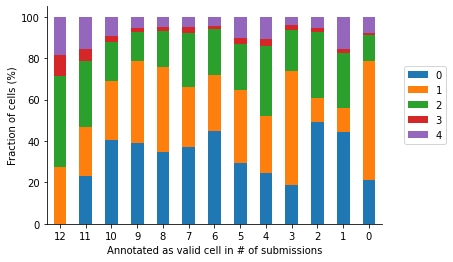

In [226]:
p6 = df_valid.T[::-1].plot(kind='bar', stacked=True, rot=0, palette='tab20')
p6.legend(bbox_to_anchor=(1.05, 0.75))
p6.set_xlabel('Annotated as valid cell in # of submissions')
p6.set_ylabel('Fraction of cells (%)')
p6.spines['top'].set_visible(False)
p6.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_overlap_valid_cells_bar.png', bbox_inches='tight')
plt.show()

In [227]:
df_valid2 = pd.crosstab(jc_bool2['sample'], jc_bool2['sum_valid'])*100

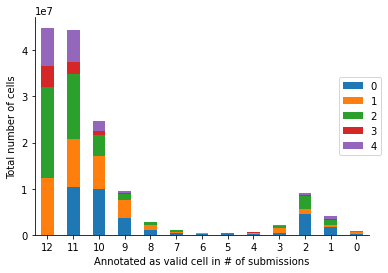

In [230]:
p6 = df_valid2.T[::-1].plot(kind='bar', stacked=True, rot=0, palette='tab20')
p6.legend(bbox_to_anchor=(1.05, 0.75))
p6.set_xlabel('Annotated as valid cell in # of submissions')
p6.set_ylabel('Total number of cells')
p6.spines['top'].set_visible(False)
p6.spines['right'].set_visible(False)
plt.savefig(f'./../figures/{today}_overlap_valid_cells_bar2.png', bbox_inches='tight')
plt.show()

## Level 1: Coarse cell type annotation

In this evaluation, we inspect the accordance of cell type annotations using the normalized mutual information criterion. We create four different versions of it, because all submissions differ in the number of valid cells to begin with and subsetting to the valid cells in the Gold standard may introduce bias. 
* Version 1: Use all cells
* Version 2: Use valid cells of the Gold standard
* Version 3: Use valid cells of the subset of Gold standard and tested group
* Version 4: Use valid cells based on the consensus (valid in 9 or more submissions)
* Version 5: Compare to consensus obtained from all submissions

In [233]:
anno_keys = [key for key in adata_con.obs_keys() if key.count('cell type lvl 1')>0]

In [234]:
anno_keys

['cell type lvl 1',
 'manual cell type lvl 1_Gold',
 'manual cell type lvl 1_p1',
 'manual cell type lvl 1_p2',
 'manual cell type lvl 1_p3',
 'manual cell type lvl 1_p4',
 'manual cell type lvl 1_p5',
 'manual cell type lvl 1_p6',
 'manual cell type lvl 1_p7.1',
 'manual cell type lvl 1_p7.2',
 'manual cell type lvl 1_p7.3',
 'manual cell type lvl 1_p7.4']

In [236]:
anno_cells = adata_con.obs[anno_keys]

In [237]:
anno_cells.head()

,cell type lvl 1,manual cell type lvl 1_Gold,manual cell type lvl 1_p1,manual cell type lvl 1_p2,manual cell type lvl 1_p3,manual cell type lvl 1_p4,manual cell type lvl 1_p5,manual cell type lvl 1_p6,manual cell type lvl 1_p7.1,manual cell type lvl 1_p7.2,manual cell type lvl 1_p7.3,manual cell type lvl 1_p7.4
0-0,T cell,not annotated,not annotated,T cell,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated
1-0,not annotated,T cell,T cell,Monocyte,T cell,not annotated,T cell,T cell,T cell,T cell,T cell,T cell
2-0,not annotated,NK cell,NK cell,not annotated,NK cell,not annotated,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell
3-0,not annotated,Monocyte,Monocyte,Monocyte,Dendritic cell,Monocyte,Monocyte,Monocyte,Monocyte,Monocyte,Monocyte,Monocyte
4-0,not annotated,NK cell,NK cell,T cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell


Version 1:

In [238]:
nmi = {}
for key in anno_keys:
    print(key)
    nmi[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_cells['manual cell type lvl 1_Gold'],
                                             labels_pred=anno_cells[key]
                                            )
    

cell type lvl 1
manual cell type lvl 1_Gold
manual cell type lvl 1_p1
manual cell type lvl 1_p2
manual cell type lvl 1_p3
manual cell type lvl 1_p4
manual cell type lvl 1_p5
manual cell type lvl 1_p6
manual cell type lvl 1_p7.1
manual cell type lvl 1_p7.2
manual cell type lvl 1_p7.3
manual cell type lvl 1_p7.4


In [239]:
nmi

{'cell type lvl 1': 0.1877543220099494,
 'manual cell type lvl 1_Gold': 1.0000000000000007,
 'manual cell type lvl 1_p1': 0.7720753951540019,
 'manual cell type lvl 1_p2': 6.728451427997715e-05,
 'manual cell type lvl 1_p3': 0.748001434331159,
 'manual cell type lvl 1_p4': 0.5932723589322614,
 'manual cell type lvl 1_p5': 0.8247337709688378,
 'manual cell type lvl 1_p6': 0.6176399791731043,
 'manual cell type lvl 1_p7.1': 0.7629915679695832,
 'manual cell type lvl 1_p7.2': 0.7901954948436208,
 'manual cell type lvl 1_p7.3': 0.7757171519090256,
 'manual cell type lvl 1_p7.4': 0.5340040681609198}

Version 2:

In [240]:
anno_cells2 = anno_cells.loc[np.invert(anno_cells['manual cell type lvl 1_Gold']=='not annotated')].copy()

In [243]:
nmi2 = {}
for key in anno_keys:
    print(key)
    nmi2[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_cells2['manual cell type lvl 1_Gold'],
                                             labels_pred=anno_cells2[key]
                                            )
    

cell type lvl 1
manual cell type lvl 1_Gold
manual cell type lvl 1_p1
manual cell type lvl 1_p2
manual cell type lvl 1_p3
manual cell type lvl 1_p4
manual cell type lvl 1_p5
manual cell type lvl 1_p6
manual cell type lvl 1_p7.1
manual cell type lvl 1_p7.2
manual cell type lvl 1_p7.3
manual cell type lvl 1_p7.4


In [244]:
nmi2

{'cell type lvl 1': 0.2158242213276121,
 'manual cell type lvl 1_Gold': 1.0000000000000009,
 'manual cell type lvl 1_p1': 0.7946791615912764,
 'manual cell type lvl 1_p2': 5.4822430665097e-05,
 'manual cell type lvl 1_p3': 0.7615958511771133,
 'manual cell type lvl 1_p4': 0.6255598523275789,
 'manual cell type lvl 1_p5': 0.8468548449179966,
 'manual cell type lvl 1_p6': 0.6600257510563424,
 'manual cell type lvl 1_p7.1': 0.8005221221472479,
 'manual cell type lvl 1_p7.2': 0.8330342463837437,
 'manual cell type lvl 1_p7.3': 0.8092533697641776,
 'manual cell type lvl 1_p7.4': 0.561949449023092}

Version 3:

In [253]:
nmi3 = {}
for key in anno_keys:
    print(key)
    if key.endswith('Gold'):
        continue
    anno_tmp = anno_cells[['manual cell type lvl 1_Gold', key]].copy()
    anno_tmp = anno_tmp.loc[np.sum(anno_tmp == 'not annotated',axis=1)==0]
    nmi3[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_tmp['manual cell type lvl 1_Gold'],
                                             labels_pred=anno_tmp[key]
                                            )

cell type lvl 1
manual cell type lvl 1_Gold
manual cell type lvl 1_p1
manual cell type lvl 1_p2
manual cell type lvl 1_p3
manual cell type lvl 1_p4
manual cell type lvl 1_p5
manual cell type lvl 1_p6
manual cell type lvl 1_p7.1
manual cell type lvl 1_p7.2
manual cell type lvl 1_p7.3
manual cell type lvl 1_p7.4


In [254]:
nmi3

{'cell type lvl 1': 0.28521830352255806,
 'manual cell type lvl 1_p1': 0.9104312167928728,
 'manual cell type lvl 1_p2': 5.516454250619642e-05,
 'manual cell type lvl 1_p3': 0.8903149927668439,
 'manual cell type lvl 1_p4': 0.9626422037335871,
 'manual cell type lvl 1_p5': 0.9424967014851582,
 'manual cell type lvl 1_p6': 0.9406883365853939,
 'manual cell type lvl 1_p7.1': 0.9594975808628545,
 'manual cell type lvl 1_p7.2': 0.9722174123770528,
 'manual cell type lvl 1_p7.3': 0.9252468681436692,
 'manual cell type lvl 1_p7.4': 0.9070846404107179}

Version 4:

In [255]:
anno_cons = anno_cells[np.sum(anno_cells =='not annotated', axis=1)<=3].copy()

In [256]:
nmi4 = {}
for key in anno_keys:
    print(key)
    if key.endswith('Gold'):
        continue
    nmi4[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_cons['manual cell type lvl 1_Gold'],
                                             labels_pred=anno_cons[key]
                                            )

cell type lvl 1
manual cell type lvl 1_Gold
manual cell type lvl 1_p1
manual cell type lvl 1_p2
manual cell type lvl 1_p3
manual cell type lvl 1_p4
manual cell type lvl 1_p5
manual cell type lvl 1_p6
manual cell type lvl 1_p7.1
manual cell type lvl 1_p7.2
manual cell type lvl 1_p7.3
manual cell type lvl 1_p7.4


In [257]:
nmi4

{'cell type lvl 1': 0.2264396016472364,
 'manual cell type lvl 1_p1': 0.8765502730902655,
 'manual cell type lvl 1_p2': 0.0004146776667183559,
 'manual cell type lvl 1_p3': 0.8382872400113939,
 'manual cell type lvl 1_p4': 0.6801418987681108,
 'manual cell type lvl 1_p5': 0.9082644704098046,
 'manual cell type lvl 1_p6': 0.7203571062783212,
 'manual cell type lvl 1_p7.1': 0.8900003094631409,
 'manual cell type lvl 1_p7.2': 0.9376235816974521,
 'manual cell type lvl 1_p7.3': 0.921209387781738,
 'manual cell type lvl 1_p7.4': 0.6252361804720274}

In [260]:
anno_cons.shape

(1074066, 12)

Version 5:

In [ ]:
nmi5 = {}
for key in anno_keys:
    print(key)
    nmi5[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=dfi['consensus label'],
                                             labels_pred=anno_cells[key]
                                            )

cell type lvl 1
manual cell type lvl 1_Gold
manual cell type lvl 1_p1
manual cell type lvl 1_p2
manual cell type lvl 1_p3
manual cell type lvl 1_p4
manual cell type lvl 1_p5
manual cell type lvl 1_p6
manual cell type lvl 1_p7.1
manual cell type lvl 1_p7.2


In [ ]:
nmi5

Let us also compute the NMI per sample.

## Level 2: Finer cell type annotation

In this evaluation, we inspect the accordance of cell type annotations using the normalized mutual information criterion. We create four different versions of it, because all submissions differ in the number of valid cells to begin with and subsetting to the valid cells in the Gold standard may introduce bias. 
* Version 1: Use all cells
* Version 2: Use valid cells of the Gold standard
* Version 3: Use valid cells of the subset of Gold standard and tested group
* Version 4: Use valid cells based on the consensus (valid in 9 or more submissions)
* Version 5: Compare to consensus obtained from all submissions

In [233]:
anno_keys2 = [key for key in adata_con.obs_keys() if key.count('cell type lvl 2')>0]

In [234]:
anno_keys2

['cell type lvl 1',
 'manual cell type lvl 1_Gold',
 'manual cell type lvl 1_p1',
 'manual cell type lvl 1_p2',
 'manual cell type lvl 1_p3',
 'manual cell type lvl 1_p4',
 'manual cell type lvl 1_p5',
 'manual cell type lvl 1_p6',
 'manual cell type lvl 1_p7.1',
 'manual cell type lvl 1_p7.2',
 'manual cell type lvl 1_p7.3',
 'manual cell type lvl 1_p7.4']

In [236]:
anno_cells2 = adata_con.obs[anno_keys2]

In [341]:
anno_cells2.head()

,cell type lvl 2,manual cell type lvl 2_Gold,manual cell type lvl 2_p1,manual cell type lvl 2_p2,manual cell type lvl 2_p3,manual cell type lvl 2_p4,manual cell type lvl 2_p5,manual cell type lvl 2_p6,manual cell type lvl 2_p7.1,manual cell type lvl 2_p7.2,manual cell type lvl 2_p7.3,manual cell type lvl 2_p7.4
0-0,CD4+ T cell,not annotated,not annotated,CD4+ T cell,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated,not annotated
1-0,not annotated,CD8+ T cell,T cell,Classical monocyte,CD8+ T cell,not annotated,not annotated,CD8+ T cell,CD8+ T cell,CD8+ T cell,CD8+ T cell,CD8+ T cell
2-0,not annotated,NK cell,NK cell,not annotated,NK cell,not annotated,not annotated,NK cell,NK cell,NK cell,NK cell,NK cell
3-0,not annotated,Classical monocyte,Classical monocyte,Classical monocyte,cDC,Classical monocyte,Classical monocyte,Classical monocyte,Classical monocyte,Classical monocyte,Classical monocyte,Classical monocyte
4-0,not annotated,NK cell,NK cell,CD8+ T cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell,NK cell


Version 1:

In [344]:
nmi01 = {}
for key in anno_keys2:
    print(key)
    nmi01[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_cells2['manual cell type lvl 2_Gold'],
                                             labels_pred=anno_cells2[key]
                                            )
    

cell type lvl 2
manual cell type lvl 2_Gold
manual cell type lvl 2_p1
manual cell type lvl 2_p2
manual cell type lvl 2_p3
manual cell type lvl 2_p4
manual cell type lvl 2_p5
manual cell type lvl 2_p6
manual cell type lvl 2_p7.1
manual cell type lvl 2_p7.2
manual cell type lvl 2_p7.3
manual cell type lvl 2_p7.4


In [345]:
nmi01

{'cell type lvl 2': 0.2024674509694901,
 'manual cell type lvl 2_Gold': 1.0,
 'manual cell type lvl 2_p1': 0.7972097496784593,
 'manual cell type lvl 2_p2': 0.00022615721478425386,
 'manual cell type lvl 2_p3': 0.7935242123087484,
 'manual cell type lvl 2_p4': 0.5847841459864065,
 'manual cell type lvl 2_p5': 0.5847841459864065,
 'manual cell type lvl 2_p6': 0.6706652036480629,
 'manual cell type lvl 2_p7.1': 0.8119972064834525,
 'manual cell type lvl 2_p7.2': 0.8371008472098507,
 'manual cell type lvl 2_p7.3': 0.8124863883944481,
 'manual cell type lvl 2_p7.4': 0.5954134393033139}

Version 2:

In [346]:
anno_cells02 = anno_cells2.loc[np.invert(anno_cells2['manual cell type lvl 2_Gold']=='not annotated')].copy()

In [347]:
nmi02 = {}
for key in anno_keys2:
    print(key)
    nmi02[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_cells02['manual cell type lvl 2_Gold'],
                                             labels_pred=anno_cells02[key]
                                            )
    

cell type lvl 2
manual cell type lvl 2_Gold
manual cell type lvl 2_p1
manual cell type lvl 2_p2
manual cell type lvl 2_p3
manual cell type lvl 2_p4
manual cell type lvl 2_p5
manual cell type lvl 2_p6
manual cell type lvl 2_p7.1
manual cell type lvl 2_p7.2
manual cell type lvl 2_p7.3
manual cell type lvl 2_p7.4


In [348]:
nmi02

{'cell type lvl 2': 0.2225725123788957,
 'manual cell type lvl 2_Gold': 1.0,
 'manual cell type lvl 2_p1': 0.8139149900567676,
 'manual cell type lvl 2_p2': 0.00023781498429224315,
 'manual cell type lvl 2_p3': 0.8106352159773668,
 'manual cell type lvl 2_p4': 0.6042890502643227,
 'manual cell type lvl 2_p5': 0.6042890502643227,
 'manual cell type lvl 2_p6': 0.7059198785478642,
 'manual cell type lvl 2_p7.1': 0.838413160106687,
 'manual cell type lvl 2_p7.2': 0.8655935358564362,
 'manual cell type lvl 2_p7.3': 0.8416885630835649,
 'manual cell type lvl 2_p7.4': 0.6248254788181741}

Version 3:

In [351]:
nmi03 = {}
for key in anno_keys2:
    print(key)
    if key.endswith('Gold'):
        continue
    anno_tmp = anno_cells2[['manual cell type lvl 2_Gold', key]].copy()
    anno_tmp = anno_tmp.loc[np.sum(anno_tmp == 'not annotated',axis=1)==0]
    nmi03[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_tmp['manual cell type lvl 2_Gold'],
                                             labels_pred=anno_tmp[key]
                                            )

cell type lvl 2
manual cell type lvl 2_Gold
manual cell type lvl 2_p1
manual cell type lvl 2_p2
manual cell type lvl 2_p3
manual cell type lvl 2_p4
manual cell type lvl 2_p5
manual cell type lvl 2_p6
manual cell type lvl 2_p7.1
manual cell type lvl 2_p7.2
manual cell type lvl 2_p7.3
manual cell type lvl 2_p7.4


In [352]:
nmi03

{'cell type lvl 2': 0.2753912611758969,
 'manual cell type lvl 2_p1': 0.9020650710884028,
 'manual cell type lvl 2_p2': 0.0002033254965544046,
 'manual cell type lvl 2_p3': 0.9113572062642236,
 'manual cell type lvl 2_p4': 0.8273239307651791,
 'manual cell type lvl 2_p5': 0.8273239307651791,
 'manual cell type lvl 2_p6': 0.9096795526502112,
 'manual cell type lvl 2_p7.1': 0.9351254463093069,
 'manual cell type lvl 2_p7.2': 0.9492505765891727,
 'manual cell type lvl 2_p7.3': 0.9230264996819875,
 'manual cell type lvl 2_p7.4': 0.9075597368150263}

Version 4:

In [353]:
anno_cons2 = anno_cells2[np.sum(anno_cells2 =='not annotated', axis=1)<=3].copy()

In [354]:
nmi04 = {}
for key in anno_keys2:
    print(key)
    if key.endswith('Gold'):
        continue
    nmi04[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=anno_cons2['manual cell type lvl 2_Gold'],
                                             labels_pred=anno_cons2[key]
                                            )

cell type lvl 2
manual cell type lvl 2_Gold
manual cell type lvl 2_p1
manual cell type lvl 2_p2
manual cell type lvl 2_p3
manual cell type lvl 2_p4
manual cell type lvl 2_p5
manual cell type lvl 2_p6
manual cell type lvl 2_p7.1
manual cell type lvl 2_p7.2
manual cell type lvl 2_p7.3
manual cell type lvl 2_p7.4


In [355]:
nmi04

{'cell type lvl 2': 0.24190460610774173,
 'manual cell type lvl 2_p1': 0.8861163486059969,
 'manual cell type lvl 2_p2': 0.001117330576760524,
 'manual cell type lvl 2_p3': 0.8913547541214167,
 'manual cell type lvl 2_p4': 0.6784356952183852,
 'manual cell type lvl 2_p5': 0.6784356952183852,
 'manual cell type lvl 2_p6': 0.7665767228017294,
 'manual cell type lvl 2_p7.1': 0.9220687730735608,
 'manual cell type lvl 2_p7.2': 0.9520964940512499,
 'manual cell type lvl 2_p7.3': 0.9217113015750406,
 'manual cell type lvl 2_p7.4': 0.6984498282407151}

In [260]:
anno_cons.shape

(1074066, 12)

Version 5:

In [356]:
nmi05 = {}
for key in anno_keys2:
    print(key)
    nmi05[key] = sklearn.metrics.normalized_mutual_info_score(labels_true=dfi2['consensus label'],
                                             labels_pred=anno_cells2[key]
                                            )

cell type lvl 2
manual cell type lvl 2_Gold
manual cell type lvl 2_p1
manual cell type lvl 2_p2
manual cell type lvl 2_p3
manual cell type lvl 2_p4
manual cell type lvl 2_p5
manual cell type lvl 2_p6
manual cell type lvl 2_p7.1
manual cell type lvl 2_p7.2
manual cell type lvl 2_p7.3
manual cell type lvl 2_p7.4


In [357]:
nmi05

{'cell type lvl 2': 0.20668860964460609,
 'manual cell type lvl 2_Gold': 0.8660877391169943,
 'manual cell type lvl 2_p1': 0.8169244097981394,
 'manual cell type lvl 2_p2': 0.0006040663826852564,
 'manual cell type lvl 2_p3': 0.8214998981127329,
 'manual cell type lvl 2_p4': 0.6073247985264224,
 'manual cell type lvl 2_p5': 0.6073247985264224,
 'manual cell type lvl 2_p6': 0.6946768447459416,
 'manual cell type lvl 2_p7.1': 0.8435590848545667,
 'manual cell type lvl 2_p7.2': 0.8586692337945417,
 'manual cell type lvl 2_p7.3': 0.832281006375747,
 'manual cell type lvl 2_p7.4': 0.6231092432784053}

Let us also compute the NMI per sample.